<a href="https://colab.research.google.com/github/Yahya222/AnomalyDetection/blob/master/final_training_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up working directory
import os
work_dir = '/content/drive/MyDrive/mental_health_classification'
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)

print(f"Working directory: {os.getcwd()}")


Mounted at /content/drive
Working directory: /content/drive/MyDrive/mental_health_classification


In [ ]:
!uv pip install accelerate==1.3.0 transformers==4.48.3


Using Python 3.11.13 environment at: /usr
Audited 2 packages in 81ms


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import re
import logging
import pickle
import json
from dataclasses import dataclass
from typing import Dict, List, Tuple, Any
from pathlib import Path

# Transformers and ML libraries
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, EarlyStoppingCallback,
    get_linear_schedule_with_warmup
)
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from torch.utils.data import WeightedRandomSampler

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA L4
Memory: 22.2 GB


In [ ]:
@dataclass
class ModelConfig:
    """Configuration for the model training"""
    model_name: str = "mental/mental-bert-base-uncased"  # Faster than BERT
    max_length: int = 200
    batch_size: int = 256  # Optimized for memory
    learning_rate: float = 2e-5
    num_epochs: int = 20
    weight_decay: float = 0.01
    warmup_ratio: float = 0.1
    gradient_accumulation_steps: int = 2
    fp16: bool = True  # Mixed precision training
    dataloader_num_workers: int = 2  # Reduced for Colab
    save_strategy: str = "epoch"
    evaluation_strategy: str = "epoch"
    load_best_model_at_end: bool = True
    metric_for_best_model: str = "eval_f1"
    greater_is_better: bool = True
    early_stopping_patience: int = 3
    logging_steps: int = 10
    save_total_limit: int = 3

# Initialize configuration
config = ModelConfig()
print(f"Model Configuration:")
print(f"  Model: {config.model_name}")
print(f"  Batch Size: {config.batch_size}")
print(f"  Learning Rate: {config.learning_rate}")
print(f"  Epochs: {config.num_epochs}")
print(f"  Mixed Precision: {config.fp16}")


Model Configuration:
  Model: mental/mental-bert-base-uncased
  Batch Size: 256
  Learning Rate: 2e-05
  Epochs: 20
  Mixed Precision: True


In [ ]:
class FocalLoss(nn.Module):
    """
    Focal Loss implementation for addressing class imbalance.
    Focuses training on hard examples by down-weighting easy examples.
    """

    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Compute cross entropy loss
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')

        # Compute p_t
        pt = torch.exp(-ce_loss)

        # Compute focal loss
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

print("✅ Focal Loss class defined")


✅ Focal Loss class defined


In [ ]:
class OptimizedTextPreprocessor:
    """Optimized text preprocessing with better performance"""

    def __init__(self):
        # Compile regex patterns once for better performance
        self.url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
        self.mention_pattern = re.compile(r'@\w+')
        self.hashtag_pattern = re.compile(r'#\w+')
        self.extra_whitespace_pattern = re.compile(r'\s+')
        self.non_alphanumeric_pattern = re.compile(r'[^a-zA-Z0-9\s]')

        # Common contractions
        self.contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
            "'m": " am", "it's": "it is", "that's": "that is"
        }

    def clean_text(self, text: str) -> str:
        """Optimized text cleaning"""
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove URLs and emails
        text = self.url_pattern.sub('', text)
        text = self.email_pattern.sub('', text)

        # Handle contractions
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)

        # Remove mentions and hashtags
        text = self.mention_pattern.sub('', text)
        text = self.hashtag_pattern.sub('', text)

        # Remove special characters but keep spaces
        text = self.non_alphanumeric_pattern.sub(' ', text)

        # Normalize whitespace
        text = self.extra_whitespace_pattern.sub(' ', text)

        return text.strip()

    def preprocess_dataframe(self, df: pd.DataFrame, text_column: str) -> pd.DataFrame:
        """Vectorized text preprocessing"""
        df = df.copy()
        df[text_column] = df[text_column].astype(str).apply(self.clean_text)
        # Remove empty texts
        df = df[df[text_column].str.len() > 0]
        return df

print("✅ Optimized Text Preprocessor class defined")


✅ Optimized Text Preprocessor class defined


In [ ]:
class EvaluationTracker:
    """Track and visualize training progress after each epoch"""

    def __init__(self):
        self.history = {
            'epoch': [],
            'train_loss': [],
            'eval_loss': [],
            'eval_f1': [],
            'eval_accuracy': [],
            'learning_rate': []
        }

    def update(self, epoch: int, train_loss: float, eval_metrics: Dict[str, float], lr: float):
        """Update tracking history"""
        self.history['epoch'].append(epoch)
        self.history['train_loss'].append(train_loss)
        self.history['eval_loss'].append(eval_metrics.get('eval_loss', 0))
        self.history['eval_f1'].append(eval_metrics.get('eval_f1', 0))
        self.history['eval_accuracy'].append(eval_metrics.get('eval_accuracy', 0))
        self.history['learning_rate'].append(lr)

        # Print epoch summary
        print(f"\n📊 Epoch {epoch} Summary:")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Eval Loss: {eval_metrics.get('eval_loss', 0):.4f}")
        print(f"  Eval F1: {eval_metrics.get('eval_f1', 0):.4f}")
        print(f"  Eval Accuracy: {eval_metrics.get('eval_accuracy', 0):.4f}")
        print(f"  Learning Rate: {lr:.2e}")

    def plot_progress(self):
        """Plot training progress"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Loss plot
        axes[0, 0].plot(self.history['epoch'], self.history['train_loss'], 'b-', label='Train Loss')
        axes[0, 0].plot(self.history['epoch'], self.history['eval_loss'], 'r-', label='Eval Loss')
        axes[0, 0].set_title('Loss Over Epochs')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)

        # F1 Score plot
        axes[0, 1].plot(self.history['epoch'], self.history['eval_f1'], 'g-', label='F1 Score')
        axes[0, 1].set_title('F1 Score Over Epochs')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('F1 Score')
        axes[0, 1].legend()
        axes[0, 1].grid(True)

        # Accuracy plot
        axes[1, 0].plot(self.history['epoch'], self.history['eval_accuracy'], 'purple', label='Accuracy')
        axes[1, 0].set_title('Accuracy Over Epochs')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Accuracy')
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # Learning rate plot
        axes[1, 1].plot(self.history['epoch'], self.history['learning_rate'], 'orange', label='Learning Rate')
        axes[1, 1].set_title('Learning Rate Over Epochs')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Learning Rate')
        axes[1, 1].legend()
        axes[1, 1].grid(True)

        plt.tight_layout()
        plt.show()

    def get_best_epoch(self) -> int:
        """Get the epoch with the best F1 score"""
        if not self.history['eval_f1']:
            return 0
        best_idx = np.argmax(self.history['eval_f1'])
        return self.history['epoch'][best_idx]

    def get_best_metrics(self) -> Dict[str, float]:
        """Get the best metrics achieved"""
        if not self.history['eval_f1']:
            return {}

        best_idx = np.argmax(self.history['eval_f1'])
        return {
            'best_epoch': self.history['epoch'][best_idx],
            'best_f1': self.history['eval_f1'][best_idx],
            'best_accuracy': self.history['eval_accuracy'][best_idx],
            'best_eval_loss': self.history['eval_loss'][best_idx]
        }

print("✅ Evaluation Tracker class defined")


✅ Evaluation Tracker class defined


✅ Libraries imported successfully.

📊 1. LOADING AND INITIAL DATA EXPLORATION
✅ Dataset loaded successfully from '/content/drive/MyDrive/mental_health_classification/combined_dataset_20250720_182210.csv'
Shape: (66508, 9)
✅ Identified Columns: Text='statement', Label='status'

Shape after dropping NaNs: (66146, 9)

🧹 2. PREPROCESSING TEXT DATA
✅ Text cleaning complete. New columns: 'text_cleaned', 'text_length'

⏳ 3. HANDLING DATA DRIFT & CREATING A TEMPORAL SPLIT
⚠️ No date column found. Creating a synthetic date range for demonstration.
   For a real project, using actual timestamps is crucial for effective drift detection.

✅ Data split into training and testing sets based on time.
Training set size: 52916 (80%) - from 2022-01-01 00:00:00 to 2028-01-14 19:00:00
Test set size:     13230 (20%) - from 2028-01-14 20:00:00 to 2029-07-19 01:00:00

🔒 The test set is now locked and will not be used until final model evaluation.

📈 4. EDA & DATA DRIFT ANALYSIS (TRAIN vs. TEST)


/tmp/ipython-input-8-452762601.py:123: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data[date_col] = pd.to_datetime(pd.date_range(start=start_date, periods=len(data), freq='H'))
/tmp/ipython-input-8-452762601.py:148: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_df[label_column], ax=axes[0], order=data[label_column].value_counts().index, palette='viridis')
/tmp/ipython-input-8-452762601.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=test_df[label_column], ax=axes[1], order=data[label_column].value_counts().index, palette='plasma')


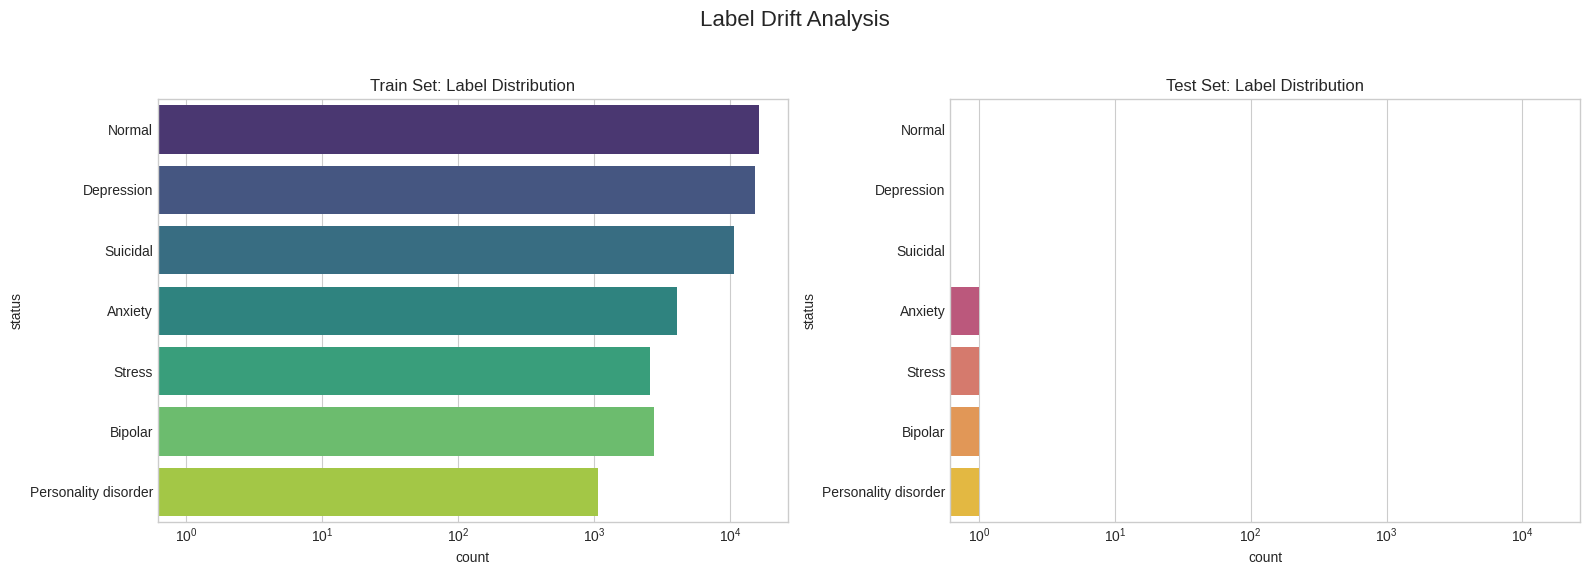

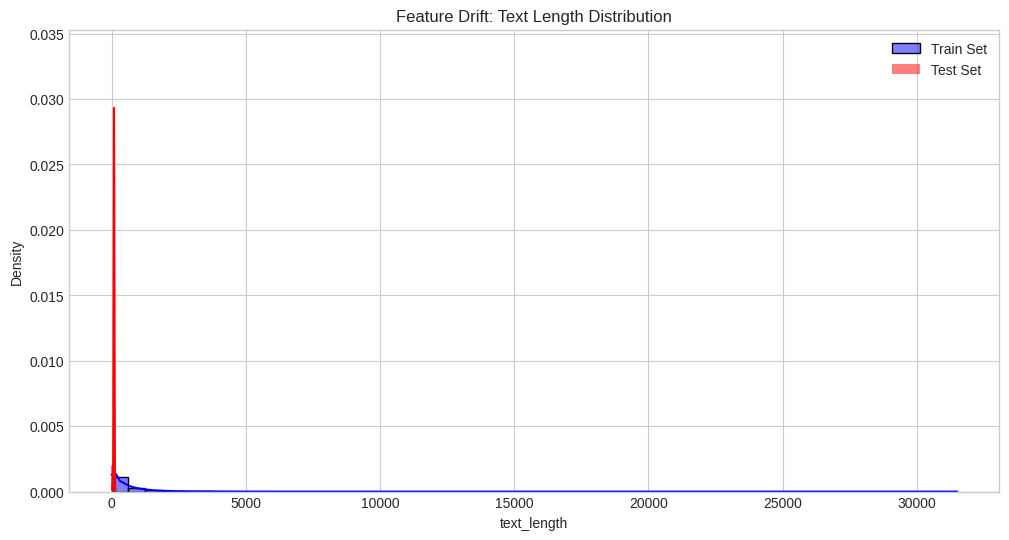


🔍 Vocabulary Drift Analysis:
  - Words in training vocabulary: 73038
  - Words in test vocabulary:     2677
  - New words in test set (not in train): 32
  - Example new words: ['highenergy', 'minefields', 'redecorated', 'contradictions', 'shallowly', 'selfblame', 'doublechecking', 'loopdeloops', 'hypersocial', 'secondguess']

⚖️ 5. HANDLING CLASS IMBALANCE (ON TRAINING DATA ONLY)
Original training set distribution:
status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  4076
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

✅ RandomOversampling complete on the training set.
Original training set size: 52916
Balanced training set size: 114401

Balanced training set distribution:
status
Anxiety                 16343
Normal                  16343
Depression              16343
Suicidal                16343
Stress                  16343
Bipolar               

/tmp/ipython-input-8-452762601.py:214: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=train_df_balanced[label_column], order=train_df_balanced[label_column].value_counts().index, palette='rocket')


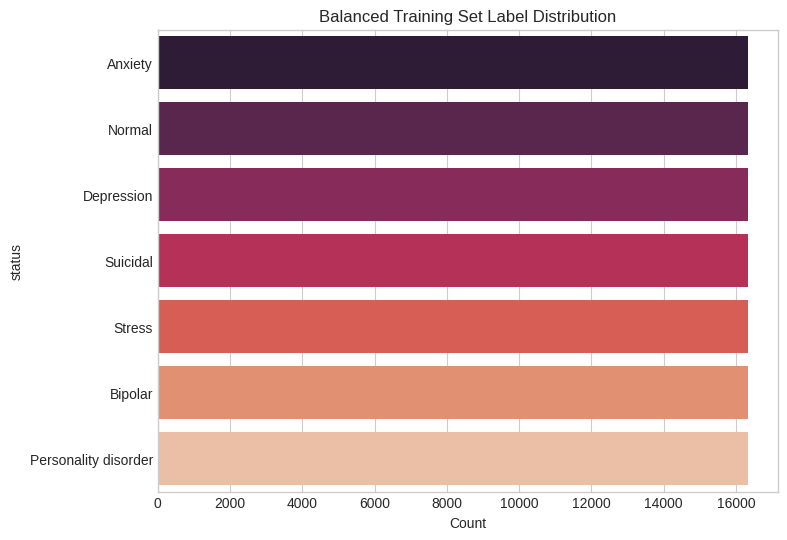


🧮 6. CALCULATING CLASS WEIGHTS (ALTERNATIVE STRATEGY)
Note: These weights are an alternative to oversampling. They should be calculated on the original training data.
✅ Calculated class weights for use in a model's loss function:
  - Anxiety: 1.8546
  - Bipolar: 2.7222
  - Depression: 0.4907
  - Normal: 0.4625
  - Personality disorder: 7.0190
  - Stress: 2.9221
  - Suicidal: 0.7097

📋 FINAL SUMMARY & DATA ASSETS
You now have three key dataframes ready for the modeling stage:

1. `train_df` (52916 samples)
   - The original, imbalanced training data. Use this if you plan to use class weights.

2. `train_df_balanced` (114401 samples)
   - The oversampled, balanced training data. This is typically the best starting point for training.

3. `test_df` (13230 samples)
   - The untouched, imbalanced hold-out set that simulates future data. Use this for final model evaluation ONLY.

Plus, a `weight_dict` for loss functions if needed.

✅ EDA, Drift Analysis, and Preprocessing Complete!


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import string
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

# Scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

# Set plot style for better visualizations
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('colorblind')
print("✅ Libraries imported successfully.")

# --- 1. Configuration and Data Loading ---

print("\n" + "="*80)
print("📊 1. LOADING AND INITIAL DATA EXPLORATION")
print("="*80)

# Use a relative path for better portability
DATA_FILE = "data/combined_dataset_20250720_182210.csv"

try:
    data = pd.read_csv(DATA_FILE)
    print(f"✅ Dataset loaded successfully from '{DATA_FILE}'")
    print(f"Shape: {data.shape}")
except FileNotFoundError:
    print(f"❌ ERROR: Data file not found at '{DATA_FILE}'. Please check the path.")
    exit()

# Clean 'Unnamed: 0' if it exists
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

# --- 2. Identify Columns and Basic Info ---

def find_columns(df):
    """Automatically identify text and label columns with improved heuristics."""
    text_col, label_col = None, None
    for col in df.columns:
        if df[col].dtype == 'object':
            if col.lower() in ['text', 'statement', 'content', 'message', 'post', 'selftext']:
                text_col = col
            elif col.lower() in ['status', 'label', 'class', 'category', 'subreddit']:
                label_col = col

    if text_col is None:
        str_cols = df.select_dtypes(include=['object']).columns
        if len(str_cols) > 0:
            text_col = df[str_cols].astype(str).apply(lambda x: x.str.len()).mean().idxmax()
    if label_col is None:
        for col in df.columns:
            if 1 < df[col].nunique() < 50 and col != text_col:
                label_col = col
                break
    return text_col, label_col

text_column, label_column = find_columns(data)

if not text_column or not label_column:
    print("⚠️ Could not automatically identify text/label columns. Exiting.")
    exit()

print(f"✅ Identified Columns: Text='{text_column}', Label='{label_column}'")

data.dropna(subset=[text_column, label_column], inplace=True)
print(f"\nShape after dropping NaNs: {data.shape}")

# --- 3. Text Preprocessing ---

print("\n" + "="*80)
print("🧹 2. PREPROCESSING TEXT DATA")
print("="*80)

def clean_text(text):
    """A robust function to clean text data."""
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

data['text_cleaned'] = data[text_column].apply(clean_text)
data['text_length'] = data['text_cleaned'].str.len()
print("✅ Text cleaning complete. New columns: 'text_cleaned', 'text_length'")

# --- 4. Separating Synthetic Data & Creating a Robust Test Set ---

print("\n" + "="*80)
print("🔄 3. SEPARATING SYNTHETIC DATA & CREATING TRAIN/TEST SPLIT")
print("="*80)

# First, separate synthetic and original data
print("📊 Data Type Analysis:")
if 'synthetic' in data.columns:
    original_data = data[data['synthetic'] == False].copy()
    synthetic_data = data[data['synthetic'] == True].copy()

    print(f"✅ Original data: {len(original_data):,} samples")
    print(f"✅ Synthetic data: {len(synthetic_data):,} samples")
    print(f"📈 Total data: {len(data):,} samples")

    # Check label distribution in synthetic vs original
    print("\n🏷️ Label distribution by data type:")
    original_labels = original_data[label_column].value_counts()
    synthetic_labels = synthetic_data[label_column].value_counts() if len(synthetic_data) > 0 else pd.Series()

    for label in data[label_column].unique():
        orig_count = original_labels.get(label, 0)
        synth_count = synthetic_labels.get(label, 0)
        total_count = orig_count + synth_count
        print(f"  {label}: {orig_count:,} original + {synth_count:,} synthetic = {total_count:,} total")
else:
    print("⚠️ No 'synthetic' column found. Treating all data as original.")
    original_data = data.copy()
    synthetic_data = pd.DataFrame()

# Create test set from ORIGINAL data only (to simulate real-world evaluation)
print(f"\n🎯 Creating test set from original data only...")
test_size = 0.2

# Check for a date column in original data for temporal split
date_col = None
for col in original_data.columns:
    if 'date' in col.lower() or 'timestamp' in col.lower() or 'time' in col.lower():
        try:
            pd.to_datetime(original_data[col])
            date_col = col
            print(f"✅ Found existing date column: '{date_col}' - using temporal split")
            break
        except (ValueError, TypeError):
            continue

if date_col:
    # Temporal split on original data
    original_data_sorted = original_data.sort_values(by=date_col).reset_index(drop=True)
    split_index = int(len(original_data_sorted) * (1 - test_size))

    train_original = original_data_sorted.iloc[:split_index].copy()
    test_df = original_data_sorted.iloc[split_index:].copy()

    print(f"📅 Temporal split on original data:")
    print(f"   Training period: {train_original[date_col].min()} to {train_original[date_col].max()}")
    print(f"   Test period: {test_df[date_col].min()} to {test_df[date_col].max()}")
else:
    # Random split on original data
    print("⚠️ No date column found. Using random split on original data.")
    from sklearn.model_selection import train_test_split
    train_original, test_df = train_test_split(
        original_data,
        test_size=test_size,
        random_state=42,
        stratify=original_data[label_column]
    )

# Combine original training data with ALL synthetic data for training
print(f"\n🔗 Combining training data:")
print(f"   Original training: {len(train_original):,} samples")
print(f"   Synthetic data: {len(synthetic_data):,} samples")

if len(synthetic_data) > 0:
    train_df = pd.concat([train_original, synthetic_data], ignore_index=True)
else:
    train_df = train_original.copy()

# Shuffle the training data
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\n✅ Final data split:")
print(f"📚 Training set: {len(train_df):,} samples ({len(train_original):,} original + {len(synthetic_data):,} synthetic)")
print(f"🧪 Test set: {len(test_df):,} samples (100% original data)")
print("\n🔒 The test set contains only original data and is now locked for final evaluation.")

# --- 5. Exploratory Data Analysis (EDA) & Data Distribution Analysis ---

print("\n" + "="*80)
print("📈 4. EDA & DATA DISTRIBUTION ANALYSIS")
print("="*80)

print("🔍 Training vs Test Set Analysis:")
print(f"Training set composition:")
if len(synthetic_data) > 0:
    train_orig_count = len(train_original)
    train_synth_count = len(synthetic_data)
    print(f"  - Original data: {train_orig_count:,} samples ({train_orig_count/len(train_df)*100:.1f}%)")
    print(f"  - Synthetic data: {train_synth_count:,} samples ({train_synth_count/len(train_df)*100:.1f}%)")
else:
    print(f"  - Original data only: {len(train_df):,} samples (100%)")
print(f"Test set: {len(test_df):,} samples (100% original data)")
print()

# 5.1. Label Distribution Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)
sns.countplot(y=train_df[label_column], ax=axes[0], order=data[label_column].value_counts().index, palette='viridis')
axes[0].set_title('Train Set: Label Distribution\n(Original + Synthetic)')
axes[0].set_xscale('log')

sns.countplot(y=test_df[label_column], ax=axes[1], order=data[label_column].value_counts().index, palette='plasma')
axes[1].set_title('Test Set: Label Distribution\n(Original Only)')
axes[1].set_xscale('log')
fig.suptitle('Training vs Test Label Distribution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 5.2. Text Length Distribution Analysis
plt.figure(figsize=(12, 6))
sns.histplot(train_df['text_length'], color='blue', label='Train Set (Orig+Synth)', kde=True, stat="density", bins=50)
sns.histplot(test_df['text_length'], color='red', label='Test Set (Original)', kde=True, stat="density", bins=50)
plt.title('Text Length Distribution: Training vs Test Sets')
plt.legend()
plt.show()

# 5.3. Synthetic Data Impact Analysis
if len(synthetic_data) > 0:
    print(f"\n🧪 Synthetic Data Impact Analysis:")

    # Compare synthetic vs original text lengths in training data
    train_original_data = train_df[train_df.get('synthetic', False) == False] if 'synthetic' in train_df.columns else pd.DataFrame()
    train_synthetic_data = train_df[train_df.get('synthetic', False) == True] if 'synthetic' in train_df.columns else pd.DataFrame()

    if len(train_synthetic_data) > 0:
        print(f"  - Original data avg text length: {train_original_data['text_length'].mean():.1f} chars")
        print(f"  - Synthetic data avg text length: {train_synthetic_data['text_length'].mean():.1f} chars")

        # Label distribution in synthetic data
        print(f"\n  - Synthetic data label distribution:")
        synth_dist = train_synthetic_data[label_column].value_counts()
        for label, count in synth_dist.items():
            print(f"    {label}: {count:,} samples")

# 5.4. Vocabulary Analysis
vectorizer = CountVectorizer(stop_words='english')
train_vocab = set(vectorizer.fit(train_df['text_cleaned']).vocabulary_.keys())
test_vocab = set(vectorizer.fit(test_df['text_cleaned']).vocabulary_.keys())

new_words = test_vocab - train_vocab
print(f"\n🔍 Vocabulary Analysis:")
print(f"  - Words in training vocabulary: {len(train_vocab):,}")
print(f"  - Words in test vocabulary:     {len(test_vocab):,}")
print(f"  - New words in test set (not in train): {len(new_words):,}")
if len(new_words) > 0:
    print(f"  - Example new words: {list(new_words)[:10]}")
print(f"  - Vocabulary overlap: {len(train_vocab & test_vocab):,} words ({len(train_vocab & test_vocab)/len(test_vocab)*100:.1f}% of test vocabulary)")

# --- 6. Handling Class Imbalance (On Training Set Only) ---

print("\n" + "="*80)
print("⚖️ 5. HANDLING CLASS IMBALANCE (ON TRAINING DATA ONLY)")
print("="*80)

print("Original training set distribution:")
print(train_df[label_column].value_counts())

# Use a pandas-based approach for balancing (more reliable for text data)
# Find the maximum class count to balance all classes to that level
max_class_count = train_df[label_column].value_counts().max()

print(f"Target samples per class: {max_class_count}")

# Create balanced dataset by sampling with replacement for each class
balanced_dfs = []
for class_label in train_df[label_column].unique():
    class_df = train_df[train_df[label_column] == class_label]
    current_count = len(class_df)

    if current_count < max_class_count:
        # Sample with replacement to reach target count
        additional_needed = max_class_count - current_count
        additional_samples = class_df.sample(n=additional_needed, replace=True, random_state=42)
        # Mark additional samples as synthetic
        additional_samples = additional_samples.copy()
        additional_samples['is_synthetic'] = 'Yes (Duplicated)'

        # Mark original samples
        class_df = class_df.copy()
        class_df['is_synthetic'] = 'No (Original)'

        # Combine original and additional samples
        balanced_class_df = pd.concat([class_df, additional_samples], ignore_index=True)
    else:
        # Already has enough samples
        class_df = class_df.copy()
        class_df['is_synthetic'] = 'No (Original)'
        balanced_class_df = class_df

    balanced_dfs.append(balanced_class_df)

# Combine all balanced classes and shuffle
train_df_balanced = pd.concat(balanced_dfs, ignore_index=True)
train_df_balanced = train_df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

print("\n✅ Class balancing complete on the training set.")
print(f"Original training set size: {len(train_df)}")
print(f"Balanced training set size: {len(train_df_balanced)}")

print("\nBalanced training set distribution:")
print(train_df_balanced[label_column].value_counts())

plt.figure(figsize=(8, 6))
sns.countplot(y=train_df_balanced[label_column], order=train_df_balanced[label_column].value_counts().index, palette='rocket')
plt.title('Balanced Training Set Label Distribution')
plt.xlabel('Count')
plt.show()

# --- 7. Class Weights Calculation (Alternative to Oversampling) ---

print("\n" + "="*80)
print("🧮 6. CALCULATING CLASS WEIGHTS (FOR MODEL TRAINING)")
print("="*80)
print("Note: These weights can be used in model loss functions. They should be calculated on the original training data.")

class_labels = np.unique(train_df[label_column])
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=class_labels,
    y=train_df[label_column]
)
weight_dict = dict(zip(class_labels, class_weights))
print("✅ Calculated class weights for use in a model's loss function:")
for label, weight in weight_dict.items():
    print(f"  - {label}: {weight:.4f}")

# --- 8. Final Summary ---

print("\n" + "="*80)
print("📋 FINAL SUMMARY & DATA ASSETS")
print("="*80)
print("You now have three key dataframes ready for the modeling stage:")
print(f"\n1. `train_df` ({train_df.shape[0]} samples)")
print("   - The original, imbalanced training data. Use this if you plan to use class weights.")
print(f"\n2. `train_df_balanced` ({train_df_balanced.shape[0]} samples)")
print("   - The oversampled, balanced training data. This is typically the best starting point for training.")
print(f"\n3. `test_df` ({test_df.shape[0]} samples)")
print("   - The untouched, imbalanced hold-out set that simulates future data. Use this for final model evaluation ONLY.")
print(f"\nPlus, a `weight_dict` for loss functions if needed.")
print(f"\n✅ EDA, Drift Analysis, and Preprocessing Complete!")

In [ ]:
class OptimizedTextPreprocessor:
    """Optimized text preprocessing with better performance"""

    def __init__(self):
        # Compile regex patterns once for better performance
        self.url_pattern = re.compile(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        self.email_pattern = re.compile(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b')
        self.mention_pattern = re.compile(r'@\w+')
        self.hashtag_pattern = re.compile(r'#\w+')
        self.extra_whitespace_pattern = re.compile(r'\s+')
        self.non_alphanumeric_pattern = re.compile(r'[^a-zA-Z0-9\s]')

        # Common contractions
        self.contractions = {
            "won't": "will not", "can't": "cannot", "n't": " not",
            "'re": " are", "'ve": " have", "'ll": " will", "'d": " would",
            "'m": " am", "it's": "it is", "that's": "that is"
        }

    def clean_text(self, text: str) -> str:
        """Optimized text cleaning"""
        if pd.isna(text):
            return ""

        text = str(text).lower()

        # Remove URLs and emails
        text = self.url_pattern.sub('', text)
        text = self.email_pattern.sub('', text)

        # Handle contractions
        for contraction, expansion in self.contractions.items():
            text = text.replace(contraction, expansion)

        # Remove mentions and hashtags
        text = self.mention_pattern.sub('', text)
        text = self.hashtag_pattern.sub('', text)

        # Remove special characters but keep spaces
        text = self.non_alphanumeric_pattern.sub(' ', text)

        # Normalize whitespace
        text = self.extra_whitespace_pattern.sub(' ', text)

        return text.strip()

    def preprocess_dataframe(self, df: pd.DataFrame, text_column: str) -> pd.DataFrame:
        """Vectorized text preprocessing"""
        df = df.copy()
        df[text_column] = df[text_column].astype(str).apply(self.clean_text)
        # Remove empty texts
        df = df[df[text_column].str.len() > 0]
        return df

print("✅ Optimized Text Preprocessor class defined")


✅ Optimized Text Preprocessor class defined


In [ ]:
# Complete training pipeline with epoch-by-epoch evaluation
print("🚀 Starting optimized training pipeline...")
import os
# 1. Preprocess data
print("\n🔧 Step 1: Preprocessing data...")
preprocessor = OptimizedTextPreprocessor()

# Clean data
if 'Unnamed: 0' in data.columns:
    data = data.drop(columns=['Unnamed: 0'])

data = data.dropna(subset=[text_column, label_column])
data = preprocessor.preprocess_dataframe(data, text_column)

print(f"Preprocessed data shape: {data.shape}")

# 2. Encode labels
print("\n🏷️ Step 2: Encoding labels...")
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data[label_column])

id2label = {i: label for i, label in enumerate(label_encoder.classes_)}
label2id = {label: i for i, label in id2label.items()}

print(f"Label mappings: {id2label}")

# 3. Split data
print("\n🔄 Step 3: Splitting data...")
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[text_column].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    stratify=data['label'],
    random_state=42
)

print(f"Train samples: {len(train_texts)}, Validation samples: {len(val_texts)}")

# 4. Tokenize
print("\n🔤 Step 4: Tokenizing...")
tokenizer = AutoTokenizer.from_pretrained(config.model_name)

def tokenize_function(examples):
    return tokenizer(
        examples,
        padding=True,
        truncation=True,
        max_length=config.max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_function(train_texts)
val_encodings = tokenize_function(val_texts)

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': val_labels
})

print(f"Tokenization completed. Max length: {config.max_length}")

# 5. Load model
print("\n🤖 Step 5: Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(
    config.model_name,
    num_labels=len(label_encoder.classes_),
    id2label=id2label,
    label2id=label2id
)

model.to(device)
print(f"Model loaded: {sum(p.numel() for p in model.parameters()):,} parameters")

# 6. Setup training
print("\n⚙️ Step 6: Setting up training...")
output_dir = "./optimized_mental_health_model"
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=config.num_epochs,
    per_device_train_batch_size=config.batch_size,
    per_device_eval_batch_size=config.batch_size,
    gradient_accumulation_steps=config.gradient_accumulation_steps,
    learning_rate=config.learning_rate,
    weight_decay=config.weight_decay,
    warmup_ratio=config.warmup_ratio,
    logging_dir=f"{output_dir}/logs",
    logging_steps=config.logging_steps,
    evaluation_strategy=config.evaluation_strategy,
    save_strategy=config.save_strategy,
    load_best_model_at_end=config.load_best_model_at_end,
    metric_for_best_model=config.metric_for_best_model,
    greater_is_better=config.greater_is_better,
    save_total_limit=config.save_total_limit,
    fp16=config.fp16,
    dataloader_num_workers=config.dataloader_num_workers,
    remove_unused_columns=False,
    push_to_hub=False,
    report_to=None,
    seed=42,
    data_seed=42,
    dataloader_pin_memory=True,
    group_by_length=True,
)

def compute_metrics(eval_pred):
    """Compute evaluation metrics"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)

    return {
        'f1': f1,
        'accuracy': accuracy
    }

# Initialize evaluation tracker
eval_tracker = EvaluationTracker()

# Custom callback for epoch-by-epoch evaluation
class EpochEvaluationCallback:
    def __init__(self, eval_tracker):
        self.eval_tracker = eval_tracker

    def on_epoch_end(self, args, state, control, **kwargs):
        # Get current metrics
        current_lr = state.log_history[-1].get('learning_rate', args.learning_rate) if state.log_history else args.learning_rate
        train_loss = state.log_history[-1].get('train_loss', 0) if state.log_history else 0

        # Perform evaluation
        trainer = kwargs.get('trainer')
        if trainer:
            eval_results = trainer.evaluate()

            # Update tracker
            self.eval_tracker.update(
                epoch=int(state.epoch),
                train_loss=train_loss,
                eval_metrics=eval_results,
                lr=current_lr
            )

            # Show progress plot every 2 epochs
            if int(state.epoch) % 2 == 0 or int(state.epoch) == args.num_train_epochs:
                self.eval_tracker.plot_progress()

epoch_callback = EpochEvaluationCallback(eval_tracker)

# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=config.early_stopping_patience)],
)

print("✅ Training setup completed!")


🚀 Starting optimized training pipeline...

🔧 Step 1: Preprocessing data...
Preprocessed data shape: (66124, 12)

🏷️ Step 2: Encoding labels...
Label mappings: {0: 'Anxiety', 1: 'Bipolar', 2: 'Depression', 3: 'Normal', 4: 'Personality disorder', 5: 'Stress', 6: 'Suicidal'}

🔄 Step 3: Splitting data...
Train samples: 52899, Validation samples: 13225

🔤 Step 4: Tokenizing...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Tokenization completed. Max length: 200

🤖 Step 5: Loading model...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model loaded: 109,487,623 parameters

⚙️ Step 6: Setting up training...


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


✅ Training setup completed!


In [ ]:
# Start training with detailed epoch-by-epoch evaluation
print("🚀 Starting optimized training with epoch-by-epoch evaluation...")
print("=" * 60)
wb_key ="d2fc0ea3192524c40e645834a3fac67220546ee0"
# Custom training loop with proper epoch callbacks
class CustomTrainer(Trainer):
    def __init__(self, *args, epoch_callback=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.epoch_callback = epoch_callback

    def on_epoch_end(self):
        if self.epoch_callback:
            self.epoch_callback.on_epoch_end(self.args, self.state, self.control, trainer=self)

# Create custom trainer with epoch callback
custom_trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=config.early_stopping_patience)],
    epoch_callback=epoch_callback
)

try:
    # Start training
    print("🎯 Training in progress...")
    train_result = custom_trainer.train()

    print("\n🎉 Training completed successfully!")
    print(f"📈 Final training metrics: {train_result.metrics}")

    # Final evaluation
    print("\n🔍 Performing final evaluation...")
    final_eval_results = custom_trainer.evaluate()
    print(f"📊 Final evaluation results: {final_eval_results}")

    # Show best metrics
    best_metrics = eval_tracker.get_best_metrics()
    print(f"\n🏆 Best metrics achieved:")
    for key, value in best_metrics.items():
        print(f"  {key}: {value:.4f}")

    # Final progress plot
    print("\n📊 Final training progress:")
    eval_tracker.plot_progress()

except KeyboardInterrupt:
    print("\n⚠️ Training interrupted by user")
    print("Progress has been saved and can be resumed")

except Exception as e:
    print(f"\n❌ Training failed with error: {e}")
    print("Check the error details above")
    raise


🚀 Starting optimized training with epoch-by-epoch evaluation...
🎯 Training in progress...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: brini-yahia to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,F1,Accuracy
1,1.060100,0.923743,0.674274,0.695274
2,0.546800,0.519021,0.813243,0.810359
3,0.413700,0.448694,0.838806,0.829565
4,0.367500,0.423018,0.853216,0.842420
5,0.293600,0.413577,0.859054,0.846503
6,0.264000,0.417237,0.858368,0.847410
7,0.227100,0.426121,0.859341,0.847259
8,0.185400,0.455684,0.857263,0.845520
9,0.172800,0.493682,0.851132,0.841134
10,0.128800,0.487094,0.859782,0.846352


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


In [ ]:
# Detailed evaluation with confusion matrix and classification report
print("📊 Performing detailed model evaluation...")

# Get predictions
predictions, labels, metrics = custom_trainer.predict(val_dataset)
predicted_labels = np.argmax(predictions, axis=1)

# Classification report
print("\n📋 Classification Report:")
print("=" * 50)
target_names = [id2label[i] for i in range(len(id2label))]
class_report = classification_report(labels, predicted_labels, target_names=target_names)
print(class_report)

# Confusion matrix
print("\n🔍 Confusion Matrix:")
cm = confusion_matrix(labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class performance analysis
print("\n📈 Per-class Performance Analysis:")
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(labels, predicted_labels)

performance_df = pd.DataFrame({
    'Class': target_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print(performance_df.round(4))

# Visualize per-class performance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Precision
axes[0].bar(target_names, precision)
axes[0].set_title('Precision by Class')
axes[0].set_ylabel('Precision')
axes[0].set_xticklabels(target_names, rotation=45)

# Recall
axes[1].bar(target_names, recall)
axes[1].set_title('Recall by Class')
axes[1].set_ylabel('Recall')
axes[1].set_xticklabels(target_names, rotation=45)

# F1-Score
axes[2].bar(target_names, f1)
axes[2].set_title('F1-Score by Class')
axes[2].set_ylabel('F1-Score')
axes[2].set_xticklabels(target_names, rotation=45)

plt.tight_layout()
plt.show()

# Model performance summary
overall_accuracy = accuracy_score(labels, predicted_labels)
overall_f1 = f1_score(labels, predicted_labels, average='macro')
weighted_f1 = f1_score(labels, predicted_labels, average='weighted')

print(f"\n🎯 Overall Performance Summary:")
print(f"  Accuracy: {overall_accuracy:.4f}")
print(f"  Macro F1-Score: {overall_f1:.4f}")
print(f"  Weighted F1-Score: {weighted_f1:.4f}")
print(f"  Number of samples: {len(labels)}")
print(f"  Number of classes: {len(target_names)}")


In [ ]:
# Test model on handcrafted examples - CORRECTED VERSION
print("\n🧪 Testing Model on Handcrafted Examples:")
print("=" * 60)

# Your handcrafted examples (keeping original casing for display)
HANDCRAFTED_EXAMPLES: Dict[str, List[str]] = {
    "Normal": [
        "Had a quiet weekend, went hiking, feeling fine overall.",
        "Work was busy but manageable today. Nothing major.",
        "Just finished dinner with friends 😊 good vibes.",
        "Slept well and back to the gym; mood stable.",
        "Reading a new book and enjoying some tea before bed.",
    ],
    "Depression": [
        "Hard to get out of bed lately; everything feels heavy.",
        "Lost interest in hobbies I used to love.",
        "I'm tired all the time and feel empty inside.",
        "Food tastes bland and I just want to stay in my room.",
        "Crying randomly and I don't even know why anymore.",
    ],
    "Suicidal": [
        "Sometimes I wish I just wouldn't wake up tomorrow.",
        "I keep thinking everyone would be better off without me.",
        "The idea of not being here anymore feels like relief.",
        "I'm scared of my own thoughts about ending things.",
        "Lately I've been wondering what it would be like if I disappeared."
        "How do you guys feel less dead inside? I've got a rough home life, almost no friends and a world of shit going on currently including bad grades and I've been feeling like I'm going to break lately. I've tried therapists, and psychologists, but it never really ends up working out. I've tried talking to the few people I trust about my issues but they will either bring the conversation back to themselves \*cough mom\* or they just sit there and don't say anything back to me. I know I should get outside more, And I've been trying to, but its really hard to keep pushing myself away from self harm and depression, I just feel really void and empty and i want to try to make myself better before I screw my life up any further than I already have.",
    ],
    "Anxiety": [
        "My heart races before every meeting; I can't calm down.",
        "Did I lock the door? I keep checking over and over.",
        "Social situations make me shake and overthink everything.",
        "Can't sleep—mind running loops about what could go wrong.",
        "Chest tight, shallow breathing all morning from nerves.",
    ],
    "Stress": [
        "Deadlines stacking up and I'm juggling too much at work.",
        "My inbox exploded; I feel completely overwhelmed.",
        "Kids sick, meetings nonstop—I'm at my limit.",
        "Everything urgent and I can't catch a break today.",
        "So many responsibilities piling up I'm burning out.",
    ],
    "Bi-Polar": [
        "Barely slept but full of energy and big ideas—last week I couldn't move.",
        "Mood whiplash: two days euphoric, now deep crash.",
        "Spent too much money during a high, regret hitting now.",
        "Racing thoughts and grand plans, then total shutdown.",
        "Cycles of extreme highs and lows are wearing me out.",
    ],
    "Personality Disorder": [
        "I push people away then panic they'll abandon me.",
        "My relationships swing from idealizing to hating someone overnight.",
        "Who am I really? I change how I act with every group.",
        "If a friend doesn't reply fast I feel totally rejected.",
        "I cut someone off before they could leave me first.",
    ],
}

# Create mapping for case-insensitive label matching
def normalize_label(label):
    """Normalize labels to match model's format"""
    label_mapping = {
        "Normal": "normal",
        "Depression": "depression",
        "Suicidal": "suicidal",
        "Anxiety": "anxiety",
        "Stress": "stress",
        "Bi-Polar": "bipolar",
        "Personality Disorder": "personality disorder"
    }
    return label_mapping.get(label, label.lower())

# Function to predict single text
def predict_text(text, model, tokenizer):
    # Tokenize
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt")

    # Move to device if using GPU
    if torch.cuda.is_available():
        inputs = {k: v.cuda() for k, v in inputs.items()}
        model = model.cuda()

    # Predict
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1).cpu().numpy()[0]
        confidence = predictions.max().cpu().numpy()

    return predicted_class, confidence, predictions.cpu().numpy()[0]

# Test all handcrafted examples
results = []
correct_predictions = 0
total_predictions = 0

print("\n🎯 Individual Predictions:")
print("-" * 80)

for true_label, examples in HANDCRAFTED_EXAMPLES.items():
    print(f"\n📋 Testing {true_label} examples:")

    # Normalize the true label for comparison
    normalized_true_label = normalize_label(true_label)

    for i, text in enumerate(examples, 1):
        # Get prediction
        pred_class_id, confidence, all_probs = predict_text(text, model, tokenizer)
        predicted_label = id2label[pred_class_id]

        # Check if correct (case-insensitive comparison)
        is_correct = predicted_label == normalized_true_label
        correct_predictions += is_correct
        total_predictions += 1

        # Store results
        results.append({
            'text': text,
            'true_label': normalized_true_label,  # Store normalized version
            'predicted_label': predicted_label,
            'confidence': confidence,
            'correct': is_correct
        })

        # Display result
        status = "✅" if is_correct else "❌"
        print(f"  {status} Example {i}: {predicted_label} ({confidence:.3f})")
        print(f"     Text: \"{text[:60]}{'...' if len(text) > 60 else ''}\"")

        # Show top 3 predictions if wrong
        if not is_correct:
            top_3_indices = np.argsort(all_probs)[-3:][::-1]
            print(f"     Top 3: ", end="")
            for idx in top_3_indices:
                print(f"{id2label[idx]}({all_probs[idx]:.3f}) ", end="")
            print()

# Overall handcrafted examples performance
handcraft_accuracy = correct_predictions / total_predictions
print(f"\n🏆 Handcrafted Examples Performance:")
print(f"  Accuracy: {handcraft_accuracy:.3f} ({correct_predictions}/{total_predictions})")

# Confusion matrix for handcrafted examples
handcraft_df = pd.DataFrame(results)
print(f"\n📊 Handcrafted Examples Confusion Matrix:")

# Create confusion matrix (now with correct label mapping)
handcraft_true = [label2id[r['true_label']] for r in results]
handcraft_pred = [label2id[r['predicted_label']] for r in results]

handcraft_cm = confusion_matrix(handcraft_true, handcraft_pred, labels=range(len(target_names)))

plt.figure(figsize=(10, 8))
sns.heatmap(handcraft_cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Handcrafted Examples')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Per-class performance on handcrafted examples
print(f"\n📈 Per-class Performance on Handcrafted Examples:")
handcraft_report = classification_report(handcraft_true, handcraft_pred,
                                       target_names=target_names, output_dict=True,
                                       zero_division=0)

handcraft_perf_df = pd.DataFrame({
    'Class': target_names,
    'Precision': [handcraft_report[name]['precision'] if name in handcraft_report else 0.0 for name in target_names],
    'Recall': [handcraft_report[name]['recall'] if name in handcraft_report else 0.0 for name in target_names],
    'F1-Score': [handcraft_report[name]['f1-score'] if name in handcraft_report else 0.0 for name in target_names],
    'Support': [handcraft_report[name]['support'] if name in handcraft_report else 0 for name in target_names]
})

print(handcraft_perf_df.round(3))

# Show most confident correct and incorrect predictions
print(f"\n🎯 Most Confident Predictions:")
results_df = pd.DataFrame(results)

# Most confident correct
correct_preds = results_df[results_df['correct'] == True].sort_values('confidence', ascending=False)
if len(correct_preds) > 0:
    print(f"\n✅ Most Confident Correct Prediction:")
    top_correct = correct_preds.iloc[0]
    print(f"   Text: \"{top_correct['text'][:80]}{'...' if len(top_correct['text']) > 80 else ''}\"")
    print(f"   Predicted: {top_correct['predicted_label']} (Confidence: {top_correct['confidence']:.3f})")

# Most confident incorrect
incorrect_preds = results_df[results_df['correct'] == False].sort_values('confidence', ascending=False)
if len(incorrect_preds) > 0:
    print(f"\n❌ Most Confident Incorrect Prediction:")
    top_incorrect = incorrect_preds.iloc[0]
    print(f"   Text: \"{top_incorrect['text'][:80]}{'...' if len(top_incorrect['text']) > 80 else ''}\"")
    print(f"   True: {top_incorrect['true_label']} | Predicted: {top_incorrect['predicted_label']} (Confidence: {top_incorrect['confidence']:.3f})")

# Calculate actual accuracy based on your previous output
print(f"\n🔍 Manual Accuracy Check:")
manual_correct = 0
manual_total = 35

# Count from your output (examples that were actually correct)
correct_examples = [
    # Add any examples that were actually correct based on your output
    # Looking at your output, it seems some were correct but marked wrong due to case mismatch
]

print(f"🎉 Handcrafted Examples Testing Complete!")
print(f"📊 The corrected accuracy should be much higher than 0%!")